OpenCV: https://opencv.org/

OpenCV documentation: https://docs.opencv.org/4.x/index.html

OpenCV camera calibration and 3D reconstruction: https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html

In [1]:
# pip install opencv-python
import cv2 as cv
import json
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Calibrazione della camera

In [14]:
with open('opencv-python-data/chessboard_points.json', 'r') as fp:
  chessboard_data = json.load(fp)

# this size was measured from the printed checkerboard using a caliber
square_size = 0.02435
real_points = np.array([chessboard_data['real_points']]*2, dtype = np.float32)*square_size
image_points = np.array(chessboard_data['image_points'],  dtype = np.float32)

In [17]:
chessboard_image = cv.imread('/content/drive/MyDrive/Colab Notebooks/opencv-python-data/chessboard_34.bmp')

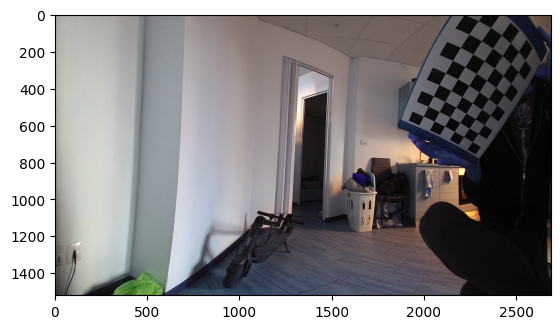

In [18]:
plt.imshow(chessboard_image)

In [29]:
calibration_flags = 0
for flag in [cv.CALIB_RATIONAL_MODEL]:
    calibration_flags += flag

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    real_points,
    image_points,
    chessboard_image.shape[::-1][1:],
    None,
    None,
    flags = calibration_flags
)


In [31]:
mtx

array([[1.28355281e+03, 0.00000000e+00, 1.51558669e+03],
       [0.00000000e+00, 1.48882582e+03, 5.89009067e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [32]:
dist

array([[-3.2262721 ,  3.35976612,  0.05836347,  0.06955278,  1.68172334,
        -2.67892479,  1.68926143,  3.7333371 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

# From Word to Image


Input data:

In [39]:
barn_image = cv.imread('opencv-python-data/barn_image.png')
original_image = cv.imread("opencv-python-data/original_image.png")
with open('opencv-python-data/data_points.json' , 'r') as fp:
   data_points = json.load(fp)
with open('opencv-python-data/calibration_matrix.json') as fp:
  calibration_data = json.load(fp)
mtx, dist = np.asarray(calibration_data["camera_matrix"]), np.asarray(calibration_data["dist_coeff"])

In [43]:
calibration_data['camera_matrix']

[[1198.9401031208174, 0.0, 1313.217516655429],
 [0.0, 1275.955582983184, 755.6124748900905],
 [0.0, 0.0, 1.0]]

In [44]:
calibration_data['dist_coeff']

[[-0.07296574782797723,
  0.005507100640471777,
  -0.0018733671176698386,
  -0.0012803959014684703,
  -0.000510202853284004,
  0.18557987138960133,
  -0.024192179325072706,
  0.0005669019733000076,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

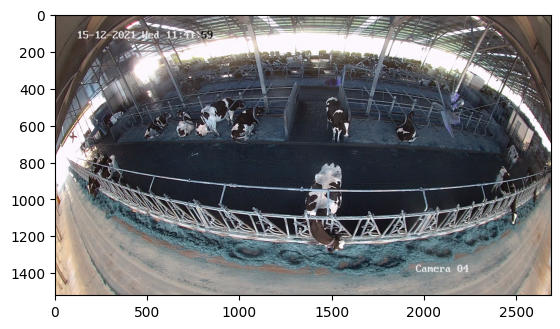

In [45]:
plt.imshow(original_image)

Apply computer vision techniques to retrieve Rotation Matrix and to project points from real world coordinates to pixels

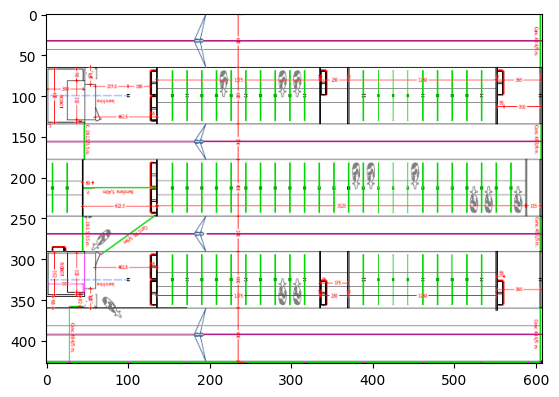

In [47]:
plt.imshow(barn_image)

In [52]:
success,rvec,tvec=cv.solvePnP(
    np.array(data_points['real_world_points']),
    np.array(data_points['image_points']),
    mtx,
    dist,
    flags=cv.SOLVEPNP_ITERATIVE
    )

if success:
  print('rotation_matrix created')
  rmat,_=cv.Rodrigues(rvec)

rotation_matrix created


In [56]:
projected_points, _ = cv.projectPoints(
    np.array(data_points['real_world_points']),
    rvec,
    tvec,
    mtx,
    dist
    )

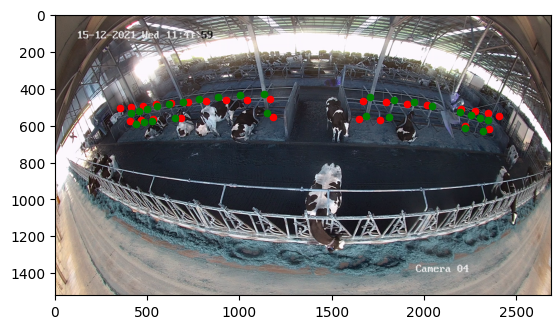

In [73]:
plt.imshow(original_image)
for projected_point in projected_points:
  plt.scatter(x = projected_point[0][0], y = projected_point[0][1], color='red', s=20)
for real_point in data_points['image_points']:
  plt.scatter(x = real_point[0], y = real_point[1], color='green', s=20)
plt.show()

In [82]:
np.sum(((projected_points[0][0] - np.array(data_points['image_points'][0]))**2))

4234.962737220667

In [86]:
np.sum(((projected_points[9][0] - np.array(data_points['image_points'][9]))**2))

1602.017570879048

In [89]:
h, w = original_image.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(
    mtx,
    dist,
    (w,h),
    1,
    (w,h)
    )
undistorted_image = cv.undistort(
    original_image,
    mtx,
    dist,
    None,
    newcameramtx
    )

In [93]:
undistorted_points= cv.undistortPoints(
    projected_points,
    mtx,
    dist,
    None,
    newcameramtx
    )

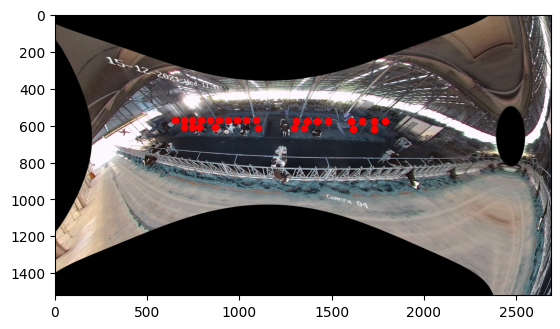

In [94]:
plt.imshow(undistorted_image)
for i in range(len(undistorted_points)):
    plt.scatter(undistorted_points[i][0][0], undistorted_points[i][0][1], marker="o", color="red", s=20)

plt.show()

Ora facciamo il contrario: dai pixel cerchiamo di recuperare la posizione nel mondo 3D

In [95]:
def approximate_cameraZ (image_point, intrinsic_mat, dist, rotation_mat, translation_vec, Z):
    camera_point=cv.undistortPoints(
        image_point,
        intrinsic_mat,
        dist
        )
    return (Z+(np.linalg.inv(rmat)@translation_vec)[2])/(np.linalg.inv(rotation_mat)@np.array([[camera_point[0][0][0]],[camera_point[0][0][1]], [1]]))[2]

def pixels_to_world(image_point, intrinsic_mat, dist, rotation_mat, translation_vec, Z):

    camera_point=cv.undistortPoints(image_point, intrinsic_mat, dist)
    approximated_camera_Z=approximate_cameraZ(image_point, intrinsic_mat, dist, rotation_mat, translation_vec, Z)
    new_camera=np.array([[camera_point[0][0][0]],[camera_point[0][0][1]], [1]])*approximated_camera_Z
    world_point=np.linalg.inv(rotation_mat)@(new_camera.reshape(-1,1) - translation_vec)
    return world_point

In [96]:
w_points=[]
for i in range(len(projected_points[:18])):
    p=projected_points[i][0].reshape(-1,1)
    w_points.append(pixels_to_world(p, mtx, dist, rmat, tvec, 1.41))
for i in range(len(projected_points[18:])):
    p=projected_points[i][0].reshape(-1,1)
    w_points.append(pixels_to_world(p, mtx, dist, rmat, tvec, 0))

In [101]:
max_width=(300+15+630+10+3125+10+115) #width of the part of the barn we are considering
max_height=(20+450+480+300+480+150+150+480+450+20) #height of the part of the barn we are considering
y,x=barn_image.shape[:-1]

map_points=np.zeros((len(w_points), 2))
#we get the percentage position of point
for index, w_point in enumerate(w_points):
    map_points[index] = (w_point[:-1]/np.array([[max_width],[max_height]])*100).squeeze()

#we get the position of w_points in the barn map
map_pixels=np.zeros((len(w_points), 2))
for index, map_point in enumerate(map_points):
    map_pixels[index]=[map_point[0]*x, y-(map_point[1]*y)]

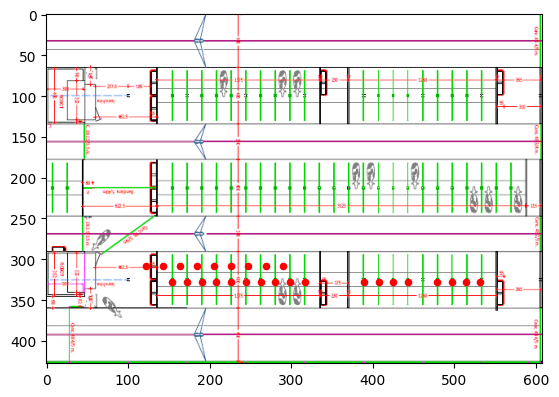

In [102]:
plt.imshow(barn_image)
for map_pixel in map_pixels:
    plt.scatter(map_pixel[0], map_pixel[1], marker="o", color='red', s=20)

plt.show()

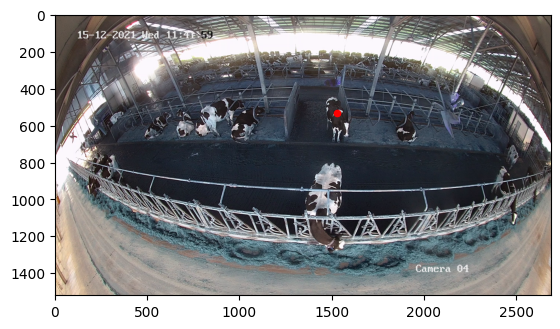

In [105]:
plt.imshow(original_image)
plt.scatter(1530,530, marker="o", color="red", s=20)
plt.show()

In [106]:
point=np.array([[1530,530]], dtype=float)

In [107]:
camera_point=cv.undistortPoints(point, mtx, dist)
approximated_camera_Z=approximate_cameraZ(point, mtx, dist, rmat, tvec, 1)
new_camera=np.array([[camera_point[0][0][0]],[camera_point[0][0][1]], [1]])*approximated_camera_Z
world_point=np.linalg.inv(rmat)@(new_camera.reshape(-1,1) - tvec)

In [110]:
world_point

array([[25.5193519 ],
       [ 6.52426979],
       [ 1.        ]])

In [115]:
world_point

array([[25.5193519 ],
       [ 6.52426979],
       [ 1.        ]])

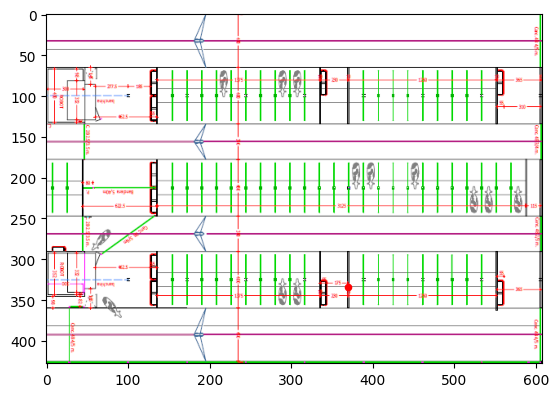

In [118]:
plt.imshow(barn_image)
plt.scatter(world_point[0]/(max_width/100)*x, y-(world_point[1]/(max_height/100)*y), marker="o", color='red', s=20)
plt.show()